## Base Configurations

In [1]:
import pymongo
import pandas as pd
from pymongo import MongoClient
from random import random
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

### Connect Mongo

In [2]:
def _connect_mongo(host, port, db):
    conn = MongoClient(host, port)
    return conn[db]

def read_mongo(db, collection, query={}, host='localhost', port=27017, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    db = _connect_mongo(host=host, port=port, db=db)
    cursor = db[collection].find(query)
    df = pd.DataFrame(list(cursor))
    if no_id:
        del df['_id']
    return df

### Read Data

In [3]:
df_covid = read_mongo("CovidData", "CovidInfo")
df_country = read_mongo("CovidData", "CountryInfo")

In [4]:
df = df_country.merge(df_covid, on='location', how='left')

df = df[['continent','location','date','total_cases','new_cases',
         'new_cases_smoothed','total_deaths','new_deaths','new_deaths_smoothed',
         'total_cases_per_million','new_cases_per_million','new_cases_smoothed_per_million',
         'total_deaths_per_million','new_deaths_per_million','new_deaths_smoothed_per_million',
         'reproduction_rate','icu_patients','icu_patients_per_million','hosp_patients',
         'hosp_patients_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million',
         'weekly_hosp_admissions','weekly_hosp_admissions_per_million','total_tests','new_tests',
         'total_tests_per_thousand','new_tests_per_thousand','new_tests_smoothed','new_tests_smoothed_per_thousand',
         'positive_rate','tests_per_case','tests_units','total_vaccinations','people_vaccinated','people_fully_vaccinated',
         'new_vaccinations','new_vaccinations_smoothed','total_vaccinations_per_hundred','people_vaccinated_per_hundred',
         'people_fully_vaccinated_per_hundred','new_vaccinations_smoothed_per_million','stringency_index','population',
         'population_density','median_age','aged_65_older','aged_70_older','gdp_per_capita',
         'cardiovasc_death_rate','diabetes_prevalence','handwashing_facilities',
         'hospital_beds_per_thousand','life_expectancy','human_development_index']]

del df_covid, df_country

df.head()

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,North America,Saint Pierre and Miquelon,2020-04-05,1.0,1.0,NaN,NaN,NaN,NaN,169.924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN
1,North America,Saint Pierre and Miquelon,2020-04-06,1.0,0.0,NaN,NaN,NaN,NaN,169.924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN
2,North America,Saint Pierre and Miquelon,2020-04-07,1.0,0.0,NaN,NaN,NaN,NaN,169.924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN
3,North America,Saint Pierre and Miquelon,2020-04-08,1.0,0.0,NaN,NaN,NaN,NaN,169.924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN
4,North America,Saint Pierre and Miquelon,2020-04-09,1.0,0.0,NaN,NaN,NaN,NaN,169.924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN


In [5]:
date_start_test = '2022-04-01'   
date_start_forecast = '2022-11-01'

df = df[df['date'] < date_start_forecast].copy()

In [6]:
df['date']

0         2020-04-05
1         2020-04-06
2         2020-04-07
3         2020-04-08
4         2020-04-09
             ...    
245247    2022-10-27
245248    2022-10-28
245249    2022-10-29
245250    2022-10-30
245251    2022-10-31
Name: date, Length: 232210, dtype: object

### Formating

In [7]:
df['date'] = pd.to_datetime(df.date)

In [8]:
(df.date.min(),df.date.max())

(Timestamp('2020-01-01 00:00:00'), Timestamp('2022-10-31 00:00:00'))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232210 entries, 0 to 245251
Data columns (total 55 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   continent                              219134 non-null  object        
 1   location                               232210 non-null  object        
 2   date                                   232210 non-null  datetime64[ns]
 3   total_cases                            218538 non-null  object        
 4   new_cases                              218375 non-null  object        
 5   new_cases_smoothed                     217179 non-null  object        
 6   total_deaths                           199309 non-null  object        
 7   new_deaths                             199296 non-null  object        
 8   new_deaths_smoothed                    198116 non-null  object        
 9   total_cases_per_million                217540 no

In [10]:
for i in df.loc[:, df.columns != 'tests_units'].columns[3:]:
    df[i] = df[i].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232210 entries, 0 to 245251
Data columns (total 55 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   continent                              219134 non-null  object        
 1   location                               232210 non-null  object        
 2   date                                   232210 non-null  datetime64[ns]
 3   total_cases                            218538 non-null  float64       
 4   new_cases                              218375 non-null  float64       
 5   new_cases_smoothed                     217179 non-null  float64       
 6   total_deaths                           199309 non-null  float64       
 7   new_deaths                             199296 non-null  float64       
 8   new_deaths_smoothed                    198116 non-null  float64       
 9   total_cases_per_million                217540 no

In [11]:
df.replace({None: 0}, inplace = True)
df.set_index('date',inplace = True)

In [12]:
df.head()

,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
date,,,,,,,,,,,,,,,,,,,,,
2020-04-05,North America,Saint Pierre and Miquelon,1.0,1.0,NaN,NaN,NaN,NaN,169.924,169.924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN
2020-04-06,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN
2020-04-07,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN
2020-04-08,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN
2020-04-09,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN


## Explanatory Data Analysis

In [13]:
df.duplicated().sum()

25730

In [14]:
df.continent.replace('',np.nan, inplace =True)  # Replacing blanks with NaN

df.dropna(subset=['continent'], inplace=True) 

In [15]:
df['continent'].value_counts()

Europe           53172
Africa           52618
Asia             49325
North America    34997
Oceania          16385
0                13076
South America    12637
Name: continent, dtype: int64

In [16]:
df['location'].value_counts()

Argentina         1035
Mexico            1035
Thailand          1032
Taiwan            1020
World             1014
                  ... 
Tokelau            498
Niue               472
Pitcairn           441
Palau              436
Western Sahara       1
Name: location, Length: 248, dtype: int64

In [17]:
df['total_deaths'].describe()

count    1.993090e+05
mean     7.440774e+04
std      3.823800e+05
min      1.000000e+00
25%      1.130000e+02
50%      1.188000e+03
75%      9.849000e+03
max      6.592990e+06
Name: total_deaths, dtype: float64

In [18]:
df['population'].describe()

count    2.312120e+05
mean     1.410083e+08
std      6.930107e+08
min      4.700000e+01
25%      8.367830e+05
50%      6.948395e+06
75%      3.369661e+07
max      7.975105e+09
Name: population, dtype: float64

In [19]:
df['new_cases'].describe()

count    2.183750e+05
mean     1.232575e+04
std      8.508334e+04
min      0.000000e+00
25%      0.000000e+00
50%      5.300000e+01
75%      9.480000e+02
max      4.083950e+06
Name: new_cases, dtype: float64

In [20]:
location_data = df.groupby('location').max('date')

In [21]:
top_countries = location_data.gdp_per_capita.sort_values(ascending =False).head(15)
top_countries

location
Qatar                   116935.600
Macao                   104861.851
Luxembourg               94277.965
Singapore                85535.383
Brunei                   71809.251
Ireland                  67335.293
United Arab Emirates     67293.483
Kuwait                   65530.537
Norway                   64800.057
Switzerland              57410.166
San Marino               56861.470
Hong Kong                56054.920
United States            54225.446
Bermuda                  50669.315
Cayman Islands           49903.029
Name: gdp_per_capita, dtype: float64

In [57]:
df2 = df.copy()
df2.reset_index(inplace = True)
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day
def funct(x):
    aa = df2.groupby('year').get_group(x).groupby(['month','day']).new_deaths.agg('sum').to_frame().reset_index()
    plt.figure(figsize=(20,8))
    sns.swarmplot(x="month", y="new_deaths", data=aa).set_title("{} Yılı Ölümler".format(x))
    sns.boxplot(x="month", y ="new_deaths", data =aa, showfliers=False, showbox=False, showcaps=False,
        showmeans=True, meanline=True, meanprops={'color': 'k', 'ls': '-', 'lw': 4}, 
        medianprops={'visible': False}, whiskerprops={'visible': False});
    plt.show()

/Users/denizsebnemakbulut/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning:

41.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



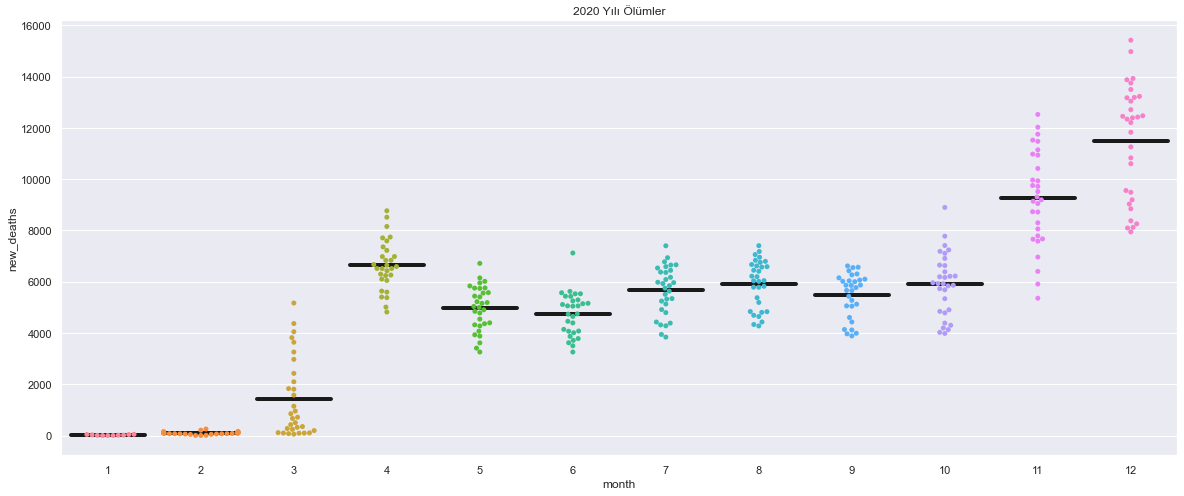

In [58]:
funct(2020)

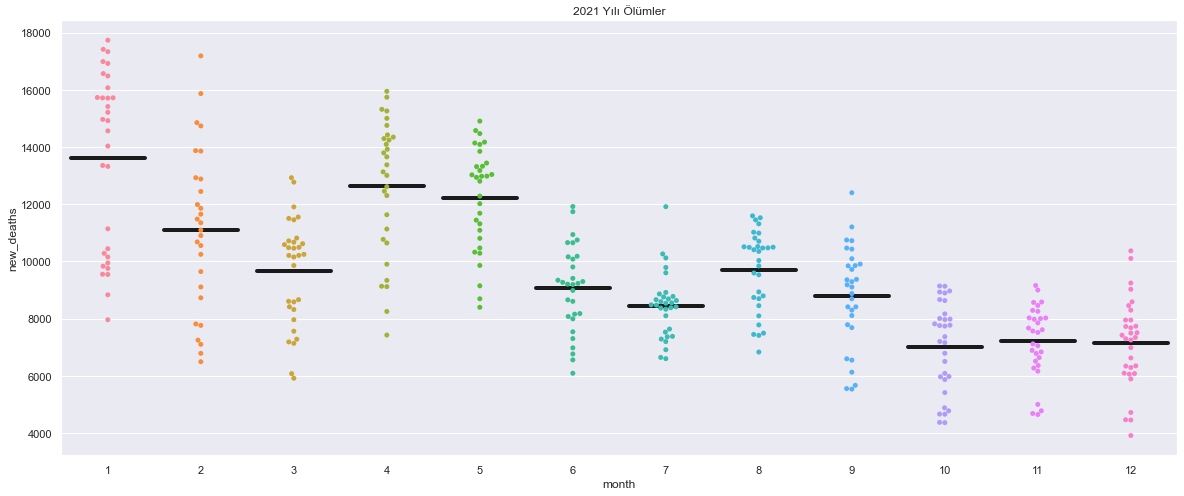

In [59]:
funct(2021)

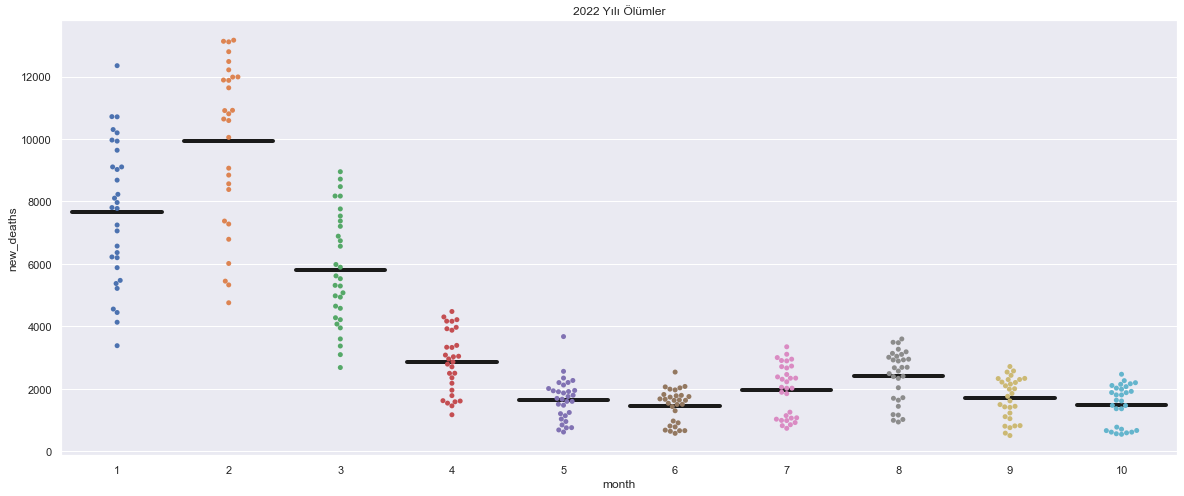

In [60]:
funct(2022)

/Users/denizsebnemakbulut/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


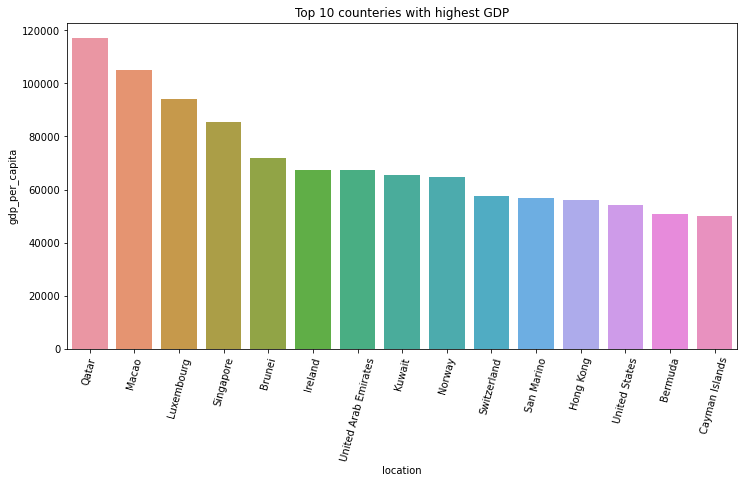

In [22]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=75)
plt.title('Top 10 counteries with highest GDP')
sns.barplot(top_countries.index, top_countries);

In [23]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [24]:
Top_10_counteries_highest_total_cases = df.groupby('location', as_index=False).max('date').sort_values('total_cases_per_million', ascending = False).head(10)

Top_10_counteries_highest_total_cases.iplot(kind='scatter', x='location',y='total_cases_per_million',mode ='markers+lines',title = 'Highest No Of Covid Cases per million',
         xTitle='Counteries',yTitle='Total Cases(in million)',colors='red',size=10)

In [25]:
Top_10_counteries_highest_total_cases.iplot(kind='scatter', x='location',y='total_deaths_per_million',mode ='markers+lines',title = 'Deaths per million',
         xTitle='Counteries',yTitle='Total Cases(in million)',colors='blue',size=15)

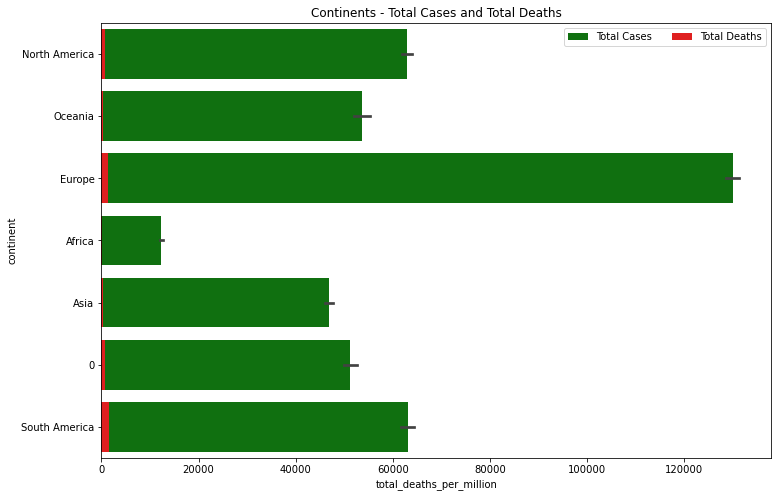

In [26]:
f, ax = plt.subplots(figsize=(12, 8))
data = df[['continent','total_cases_per_million','total_deaths_per_million']]
data.sort_values('total_cases_per_million',ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x="total_cases_per_million", y="continent", data=df,label="Total Cases", color="green")

sns.set_color_codes("muted")
sns.barplot(x="total_deaths_per_million", y="continent", data=df, label="Total Deaths", color="red")
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set_title('Continents - Total Cases and Total Deaths');
# ax.set(xlim=(0, 35), ylabel="",xlabel="Cases")
# sns.despine(left=True, bottom=True)

Text(0, 0.5, 'num deaths')

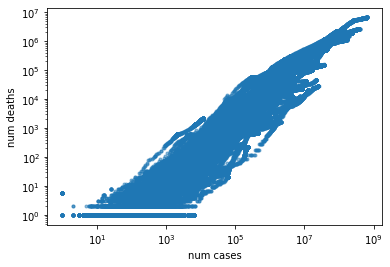

In [27]:
plt.loglog(df['total_cases'], df['total_deaths'], '.', alpha=0.5)
plt.xlabel('num cases')
plt.ylabel('num deaths')

In [30]:
df['TARGET'] = df.groupby('location')['new_cases'].shift(-1) ## Tomorrow's case will be our prediction
df.dropna(subset=['TARGET'], inplace = True)
df.head()

,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,TARGET
date,,,,,,,,,,,,,,,,,,,,,
2020-04-05,North America,Saint Pierre and Miquelon,1.0,1.0,NaN,NaN,NaN,NaN,169.924,169.924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN,0.0
2020-04-06,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN,0.0
2020-04-07,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN,0.0
2020-04-08,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN,0.0
2020-04-09,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.07,NaN,0.0


In [31]:
def one_col_corr(df, col, t = False, cmin = -1, cmax = 1, figsize = (4, 20), annot = True, linewidths = .5):
    sns.set(rc={'figure.figsize':figsize})
    heat = df.corr()[[col]].sort_values(col, ascending = False).drop(col, axis = 0).query(col + '>=' + str(cmin) + ' and ' + col + '<=' + str(cmax))
    if t:
        heat = heat.T
    sns.heatmap(heat, annot = annot, linewidths = linewidths)

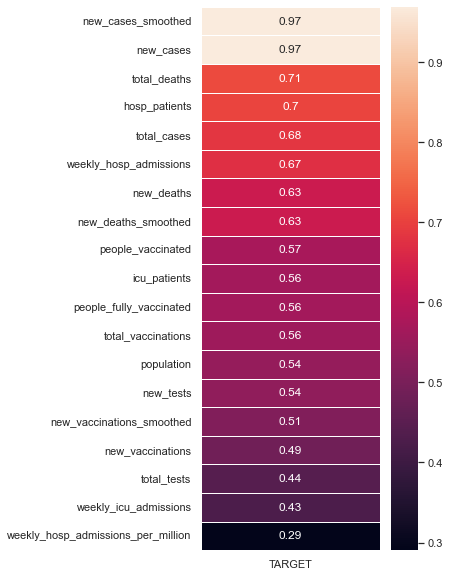

In [32]:
one_col_corr(df, 'TARGET', cmin = 0.29, figsize = (4, 10))

In [33]:
df_tur = df[df['location'] == 'Turkey']
df_tur.head()

,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,TARGET
date,,,,,,,,,,,,,,,,,,,,,
2020-03-11,Asia,Turkey,1.0,1.0,NaN,NaN,NaN,NaN,0.012,0.012,...,8.153,5.061,25129.341,171.285,12.13,NaN,2.81,77.69,0.82,0.0
2020-03-12,Asia,Turkey,1.0,0.0,NaN,NaN,NaN,NaN,0.012,0.000,...,8.153,5.061,25129.341,171.285,12.13,NaN,2.81,77.69,0.82,4.0
2020-03-13,Asia,Turkey,5.0,4.0,NaN,NaN,NaN,NaN,0.059,0.047,...,8.153,5.061,25129.341,171.285,12.13,NaN,2.81,77.69,0.82,0.0
2020-03-14,Asia,Turkey,5.0,0.0,NaN,NaN,NaN,NaN,0.059,0.000,...,8.153,5.061,25129.341,171.285,12.13,NaN,2.81,77.69,0.82,1.0
2020-03-15,Asia,Turkey,6.0,1.0,NaN,NaN,NaN,NaN,0.070,0.012,...,8.153,5.061,25129.341,171.285,12.13,NaN,2.81,77.69,0.82,12.0


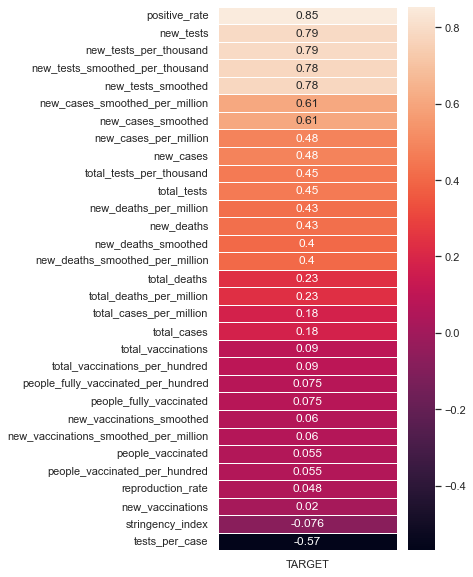

In [34]:
one_col_corr(df_tur, 'TARGET', figsize = (4, 10))

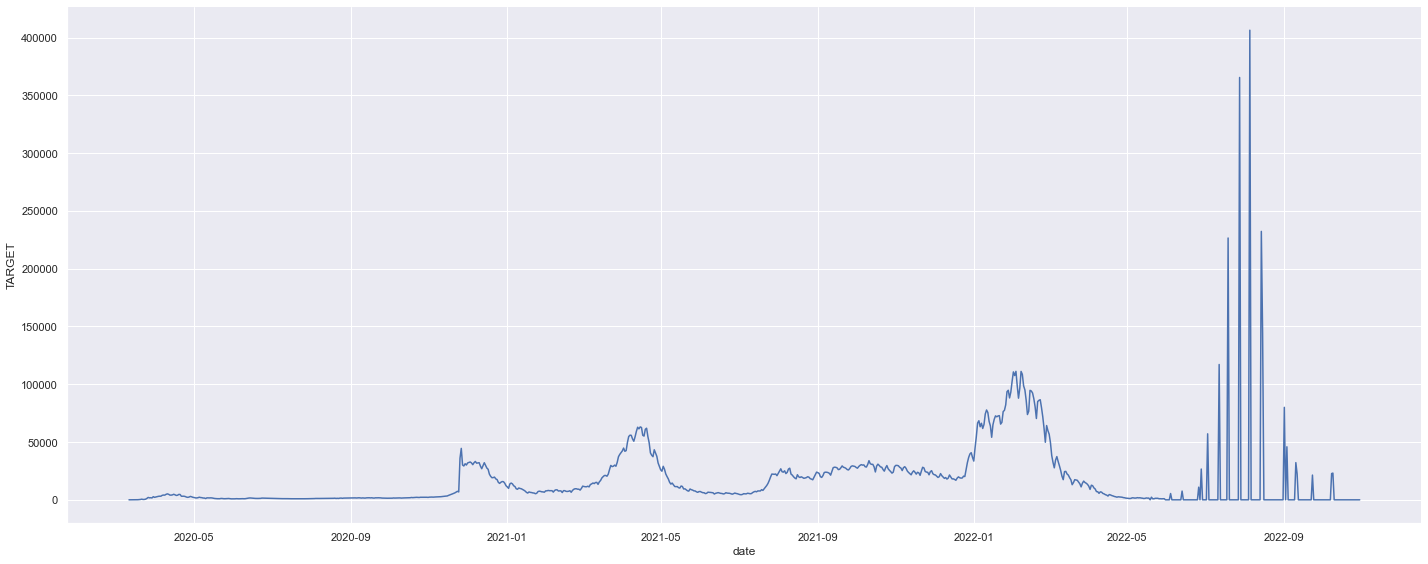

In [35]:
sns.relplot(x = 'date', y = 'TARGET', kind = 'line',  data = df_tur, height = 8, aspect = 2.5)

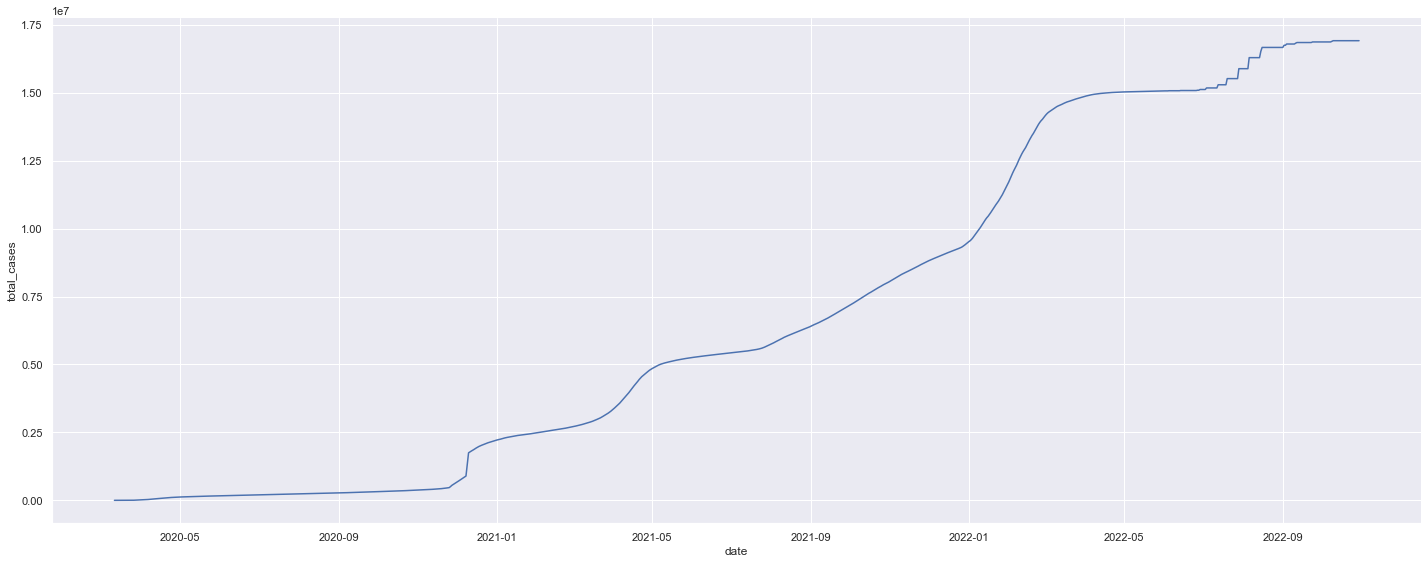

In [36]:
sns.relplot(x = 'date', y = 'total_cases', kind = 'line',  data = df_tur, height = 8, aspect = 2.5)

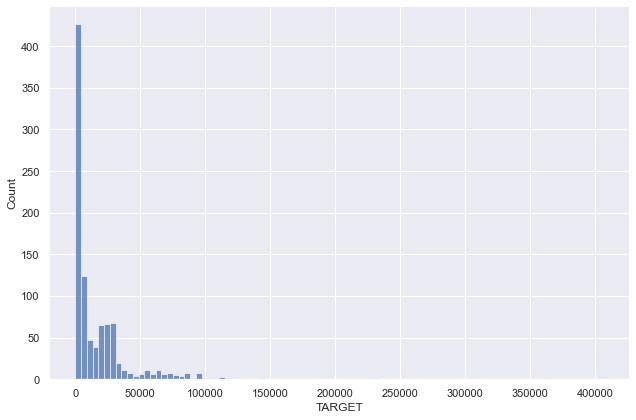

In [37]:
sns.displot(x = 'TARGET', data = df_tur, height = 6, aspect = 1.5)

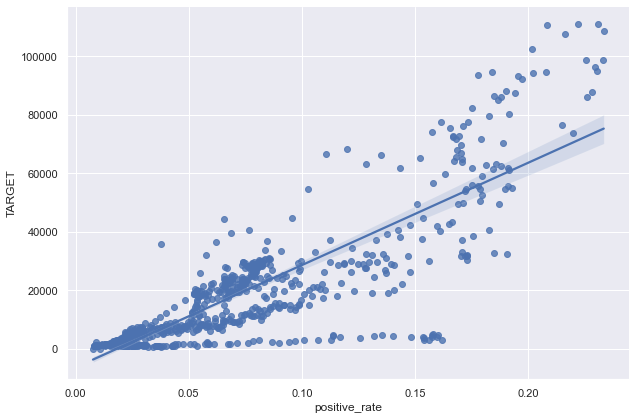

In [38]:
sns.lmplot(x = 'positive_rate', y = 'TARGET', data = df_tur, height = 6, aspect = 1.5)

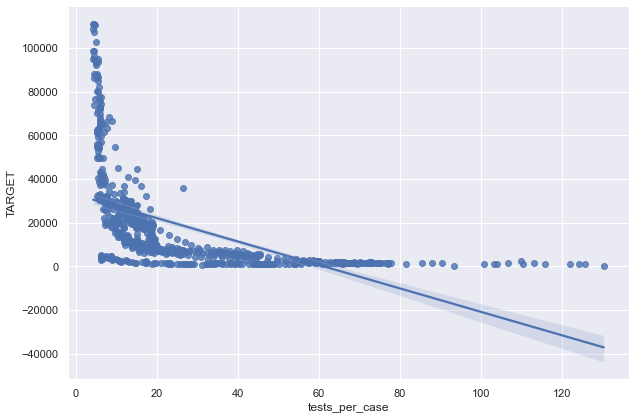

In [39]:
sns.lmplot(x = 'tests_per_case', y = 'TARGET', data = df_tur, height = 6, aspect = 1.5)

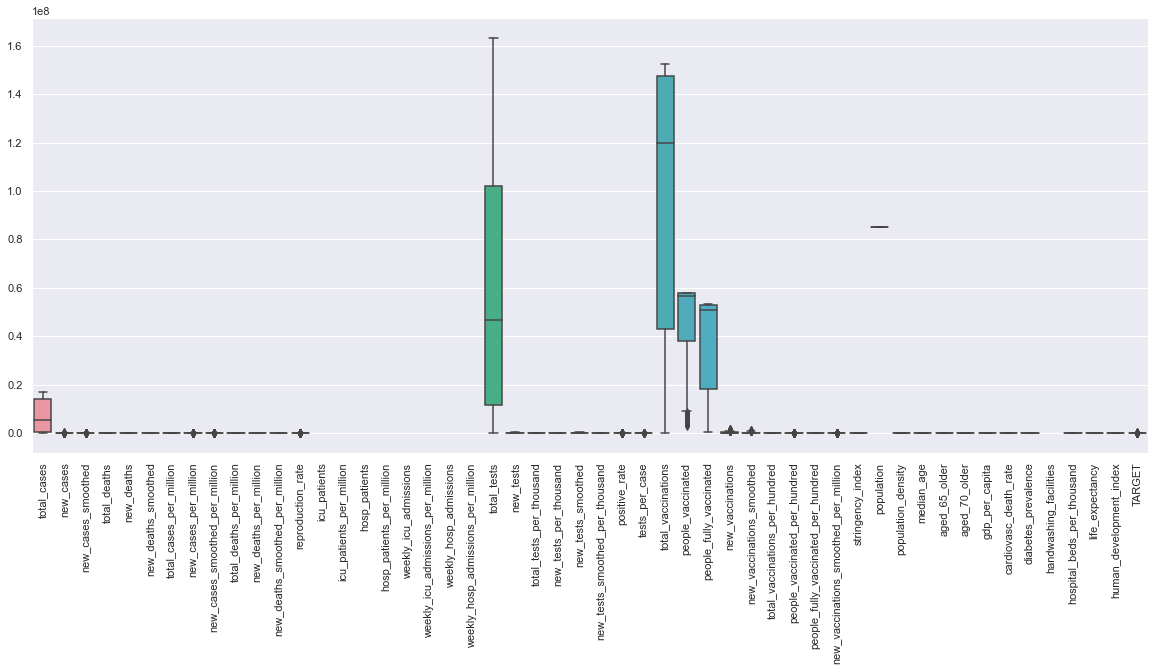

In [40]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.boxplot(data = df_tur)
plt.xticks(rotation=90)
plt.show()

### Target Value

Target values should be tomorrow's new cases. You should use 'TARGET' column in your models.

In [41]:
df['TARGET'] = df.groupby('location')['new_cases'].shift(-1) ## Tomorrow's case will be our prediction
df.dropna(subset=['TARGET'], inplace = True)
df.tail()

,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,TARGET
date,,,,,,,,,,,,,,,,,,,,,
2022-10-25,Africa,Egypt,515645.0,0.0,0.0,24798.0,0.0,0.143,4645.865,0.0,...,5.159,2.891,10550.206,525.432,17.31,89.827,1.6,71.99,0.707,0.0
2022-10-26,Africa,Egypt,515645.0,0.0,0.0,24798.0,0.0,0.000,4645.865,0.0,...,5.159,2.891,10550.206,525.432,17.31,89.827,1.6,71.99,0.707,0.0
2022-10-27,Africa,Egypt,515645.0,0.0,0.0,24798.0,0.0,0.000,4645.865,0.0,...,5.159,2.891,10550.206,525.432,17.31,89.827,1.6,71.99,0.707,0.0
2022-10-28,Africa,Egypt,515645.0,0.0,0.0,24798.0,0.0,0.000,4645.865,0.0,...,5.159,2.891,10550.206,525.432,17.31,89.827,1.6,71.99,0.707,0.0
2022-10-29,Africa,Egypt,515645.0,0.0,0.0,24798.0,0.0,0.000,4645.865,0.0,...,5.159,2.891,10550.206,525.432,17.31,89.827,1.6,71.99,0.707,0.0


## Feature Extraction

Examples are given to you below. You may increase the number of features extracted.

In [42]:
df.reset_index(inplace = True)

df['new_cases_avg_3g'] = df.groupby('location')['new_cases'].rolling(3, min_periods=1).mean().reset_index(0,drop=True) # Last 3 days avg
df['daily_death_ratio'] = round(df['new_deaths']/df['total_deaths'],5)
df['total_cases/total_tests'] = round(df['total_cases']/df['total_tests'],5)
df['hosp_patient_ratio'] = round(df['hosp_patients']/df['total_cases'],5)
df['icu_patient_ratio'] = round(df['icu_patients']/df['hosp_patients'],5)
df.replace([np.inf, -np.inf], 0, inplace=True)

In [43]:
df.head()

,date,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,TARGET,new_cases_avg_3g,daily_death_ratio,total_cases/total_tests,hosp_patient_ratio,icu_patient_ratio
0,2020-04-05,North America,Saint Pierre and Miquelon,1.0,1.0,NaN,NaN,NaN,NaN,169.924,...,NaN,NaN,81.07,NaN,0.0,1.000000,NaN,NaN,NaN,NaN
1,2020-04-06,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,...,NaN,NaN,81.07,NaN,0.0,0.500000,NaN,NaN,NaN,NaN
2,2020-04-07,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,...,NaN,NaN,81.07,NaN,0.0,0.333333,NaN,NaN,NaN,NaN
3,2020-04-08,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,...,NaN,NaN,81.07,NaN,0.0,0.000000,NaN,NaN,NaN,NaN
4,2020-04-09,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,...,NaN,NaN,81.07,NaN,0.0,0.000000,NaN,NaN,NaN,NaN


In [44]:
df = df[df['continent'] != 0]
encoder_continent = LabelEncoder()
encoder_location = LabelEncoder()
# Fit the encoders on the data
encoder_continent.fit(df['continent'])
encoder_location.fit(df['location'])

df['continent_num'] = encoder_continent.transform(df['continent'])
df['location_num'] = encoder_location.transform(df['location'])
df = pd.concat([df, pd.get_dummies(df.tests_units)], 1).drop(columns = ['tests_units'])

/var/folders/q0/6cs9t49s3ms99pvrvwz04mzc0000gn/T/ipykernel_76415/4269182226.py:10: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.



## Modeling

In [45]:
df_train = df[df['date'] < date_start_test].copy()
df_test = df[(df['date'] >= date_start_test) & (df['date'] < date_start_forecast)].copy()

In [46]:
df_train.set_index('date',inplace = True)
df_train.head()

,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,total_cases/total_tests,hosp_patient_ratio,icu_patient_ratio,continent_num,location_num,0,people tested,samples tested,tests performed,units unclear
date,,,,,,,,,,,,,,,,,,,,,
2020-04-05,North America,Saint Pierre and Miquelon,1.0,1.0,NaN,NaN,NaN,NaN,169.924,169.924,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2020-04-06,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2020-04-07,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2020-04-08,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2020-04-09,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0


In [47]:
df_test.set_index('date',inplace = True)
df_test.head()

,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,total_cases/total_tests,hosp_patient_ratio,icu_patient_ratio,continent_num,location_num,0,people tested,samples tested,tests performed,units unclear
date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,North America,Saint Pierre and Miquelon,2236.0,279.0,43.714,1.0,0.0,0.0,379949.023,47408.666,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2022-04-02,North America,Saint Pierre and Miquelon,2236.0,0.0,43.714,1.0,0.0,0.0,379949.023,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2022-04-03,North America,Saint Pierre and Miquelon,2236.0,0.0,43.714,1.0,0.0,0.0,379949.023,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2022-04-04,North America,Saint Pierre and Miquelon,2236.0,0.0,43.714,1.0,0.0,0.0,379949.023,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2022-04-05,North America,Saint Pierre and Miquelon,2236.0,0.0,43.714,1.0,0.0,0.0,379949.023,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0


In [48]:
df_train.head()

,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,total_cases/total_tests,hosp_patient_ratio,icu_patient_ratio,continent_num,location_num,0,people tested,samples tested,tests performed,units unclear
date,,,,,,,,,,,,,,,,,,,,,
2020-04-05,North America,Saint Pierre and Miquelon,1.0,1.0,NaN,NaN,NaN,NaN,169.924,169.924,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2020-04-06,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2020-04-07,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2020-04-08,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2020-04-09,North America,Saint Pierre and Miquelon,1.0,0.0,NaN,NaN,NaN,NaN,169.924,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0


In [49]:
df_test.head()

,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,...,total_cases/total_tests,hosp_patient_ratio,icu_patient_ratio,continent_num,location_num,0,people tested,samples tested,tests performed,units unclear
date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,North America,Saint Pierre and Miquelon,2236.0,279.0,43.714,1.0,0.0,0.0,379949.023,47408.666,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2022-04-02,North America,Saint Pierre and Miquelon,2236.0,0.0,43.714,1.0,0.0,0.0,379949.023,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2022-04-03,North America,Saint Pierre and Miquelon,2236.0,0.0,43.714,1.0,0.0,0.0,379949.023,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2022-04-04,North America,Saint Pierre and Miquelon,2236.0,0.0,43.714,1.0,0.0,0.0,379949.023,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0
2022-04-05,North America,Saint Pierre and Miquelon,2236.0,0.0,43.714,1.0,0.0,0.0,379949.023,0.000,...,NaN,NaN,NaN,3,166,1,0,0,0,0


In [50]:
X_train = df_train.drop(columns = ['TARGET','location','continent']).values
X_test = df_test.drop(columns = ['TARGET','location','continent']).values
y_train = df_train['TARGET'].values
y_test = df_test['TARGET'].values

In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [52]:
pipeline = Pipeline([('scaler',MinMaxScaler()),('regressor', XGBRegressor())])

In [53]:
parameters = {'regressor__nthread':[4], 
              'regressor__objective':['reg:linear'],
              'regressor__learning_rate': [.03, 0.05, .07],
              'regressor__max_depth': [5, 6, 7],
              'regressor__min_child_weight': [4],
              'regressor__subsample': [0.7],
              'regressor__colsample_bytree': [0.7],
              'regressor__n_estimators': [500]}

In [ ]:
gsearch = GridSearchCV(pipeline, parameters)
gsearch.fit(X_train, y_train)

In [ ]:
print("Best parameter (CV score=%0.3f):" % gsearch.best_score_)
print(gsearch.best_params_)

In [55]:
pipeline = Pipeline([('scaler',MinMaxScaler()),('regressor', XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03, max_depth=5, min_child_weight= 4, n_estimators= 500, nthread = 4, objective = 'reg:linear', subsample= 0.7))])

In [56]:
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)
r2 = r2_score(y_test, pred)
print('R2 Score : %f' %(r2))

[21:57:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

In [ ]:
X_test = df_test[df_test['location'] == 'Turkey'].drop(columns = ['TARGET','location','continent']).values
y_test = df_test[df_test['location'] == 'Turkey']['TARGET'].values

In [ ]:
pred = pipeline.predict(X_test)
r2 = r2_score(y_test, pred)
print('R2 Score : %f' %(r2))

### Model Performance

In [ ]:
pipeline.predict(df_train.drop(columns = ['TARGET','location','continent']))

In [ ]:
df_train.info()

### Save Model

In [ ]:
model = pipeline.steps[1][1]

In [ ]:
df_features = pd.DataFrame(model.feature_importances_, columns = ['Importance'],
             index = df_train.drop(columns = ['TARGET','location','continent']).columns).sort_values('Importance', ascending = False).reset_index()
df_features.rename(columns = {'index':'Variable'}, inplace = True)

In [ ]:
model_file = 'finalized_model.pickle'
pickle.dump(model, open(model_file, 'wb')) # model is your final model object.

variable_file = 'model_variables.pickle'
pickle.dump(df_features, open(variable_file, 'wb')) # df_features is dataframe that holds final model variables.